# Amod Mental Health Counseling Conversations: EDA

Исследовательский анализ корпуса реальных пар вопрос–ответ между пользователями и лицензированными психологами.


In [1]:
%pip -q install datasets seaborn wordcloud nltk scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud

import nltk
from nltk.stem import PorterStemmer

sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["figure.dpi"] = 120
nltk.download("punkt", quiet=True)


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [7]:
ds_any = load_dataset("Amod/mental_health_counseling_conversations")
if isinstance(ds_any, dict):
    first_split = next(iter(ds_any.keys()))
    ds = ds_any[first_split]
else:
    ds = ds_any

df = ds.to_pandas()
df.columns = [c.lower() for c in df.columns]
col_map = {}
if "context" in df.columns:
    col_map["context"] = "context"
elif "input" in df.columns:
    col_map["input"] = "context"
if "response" in df.columns:
    col_map["response"] = "response"
elif "output" in df.columns:
    col_map["output"] = "response"

df = df[list(col_map.keys())].rename(columns=col_map)
print({"rows": len(df), "columns": df.columns.tolist()})
df.head(3)


{'rows': 3512, 'columns': ['context', 'response']}


,context,response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...


In [15]:
df["context"] = df["context"].astype(str).str.strip()
df["response"] = df["response"].astype(str).str.strip()
nonempty = (df["context"].str.len() > 0) & (df["response"].str.len() > 0)
df = df[nonempty].copy()
df.drop_duplicates(subset=["context", "response"], inplace=True)
df.reset_index(drop=True, inplace=True)
print({"rows_after_basic_filters": len(df)})


{'rows_after_basic_filters': 2467}


In [16]:
def count_words(text: str) -> int:
    return len(re.findall(r"[A-Za-z']+", text))

df["context_words"] = df["context"].map(count_words)
df["response_words"] = df["response"].map(count_words)

df = df[(df["context_words"] >= 5) & (df["response_words"] >= 5)].copy()
df.reset_index(drop=True, inplace=True)
print({"rows_after_length_filters": len(df)})


{'rows_after_length_filters': 2459}


In [17]:
stemmer = PorterStemmer()
stopwords = set(ENGLISH_STOP_WORDS)
pattern = re.compile(r"[A-Za-z']+")

def normalize(text: str, do_stem: bool = True) -> list[str]:
    tokens = pattern.findall(text.lower())
    tokens = [t for t in tokens if t not in stopwords and len(t) > 2]
    if do_stem:
        tokens = [stemmer.stem(t) if len(t) >= 4 else t for t in tokens]
    return tokens

df["context_tokens"] = df["context"].map(lambda x: normalize(x, True))
df["response_tokens"] = df["response"].map(lambda x: normalize(x, True))
print(df[["context_words", "response_words"]].describe().T)


                 count        mean         std  min   25%    50%    75%  \
context_words   2459.0   58.110614   52.293112  5.0  30.0   48.0   69.0   
response_words  2459.0  187.674258  200.853782  6.0  97.0  149.0  227.0   

                   max  
context_words    534.0  
response_words  6130.0  


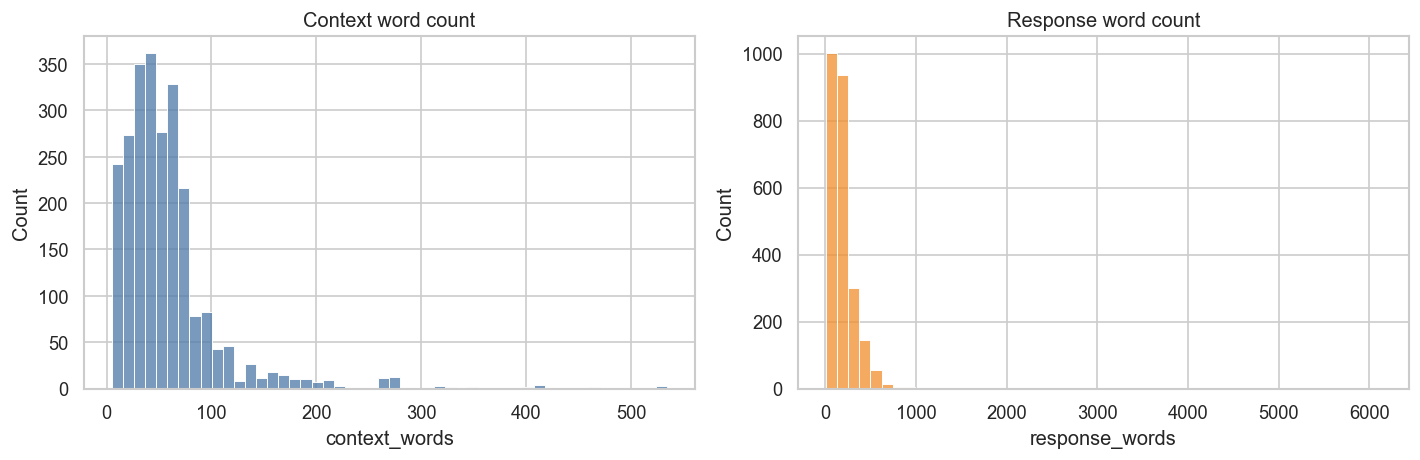

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df["context_words"], bins=50, ax=ax[0], color="#4e79a7")
ax[0].set_title("Context word count")
sns.histplot(df["response_words"], bins=50, ax=ax[1], color="#f28e2c")
ax[1].set_title("Response word count")
plt.tight_layout()
plt.show()


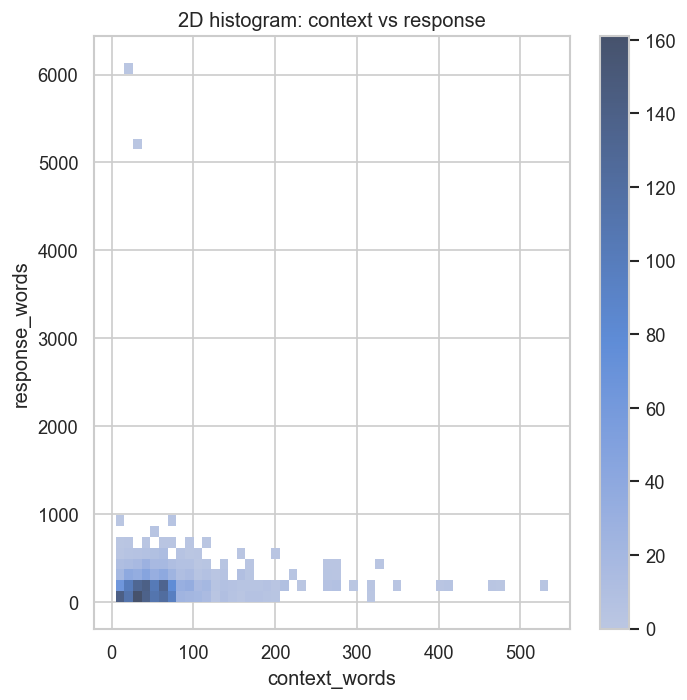

In [24]:
plt.figure(figsize=(6, 6))
sns.histplot(x=df["context_words"], y=df["response_words"], bins=50, cbar=True)
plt.xlabel("context_words")
plt.ylabel("response_words")
plt.title("2D histogram: context vs response")
plt.tight_layout()
plt.show()


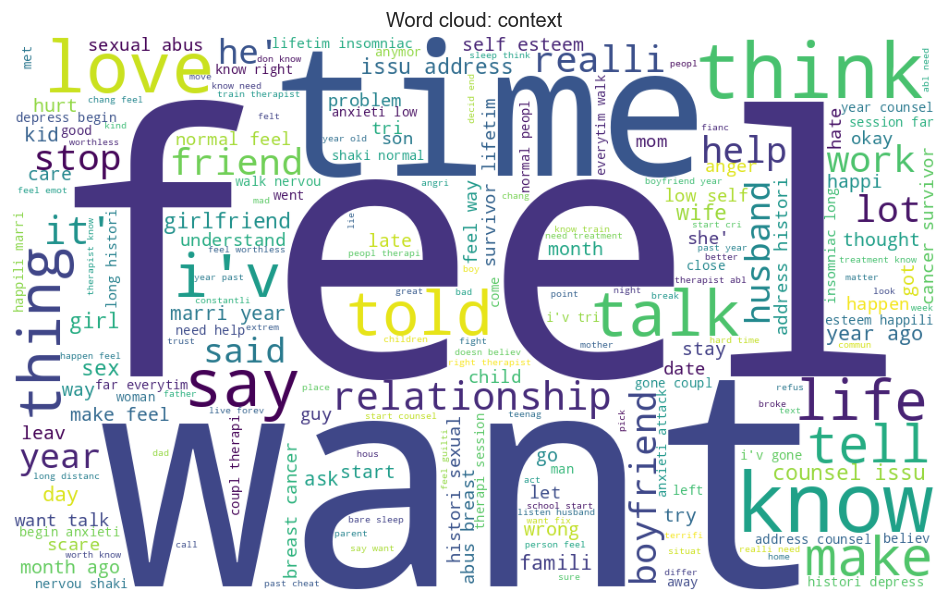

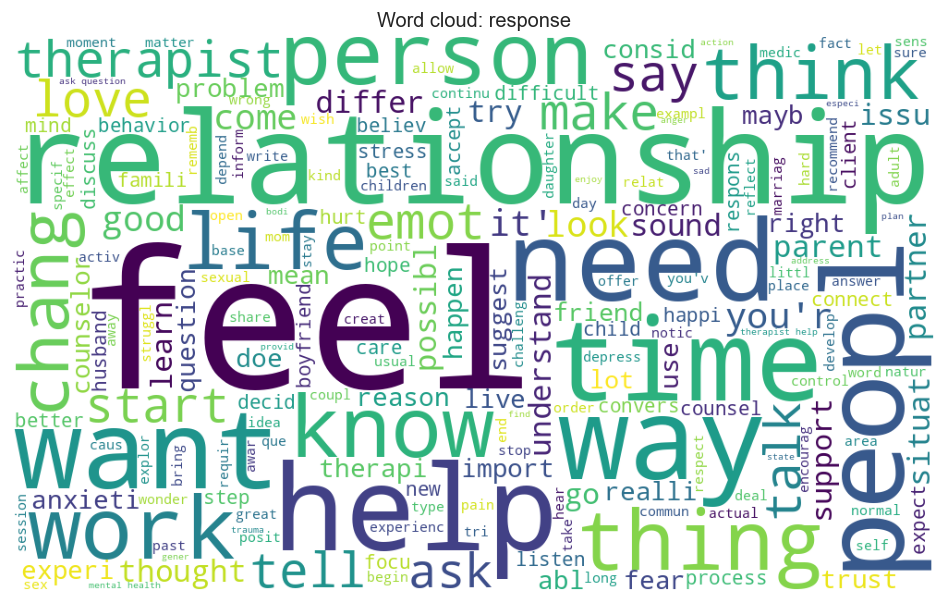

In [22]:
text_ctx = " ".join(" ".join(toks) for toks in df["context_tokens"])[:3_000_000]
text_rsp = " ".join(" ".join(toks) for toks in df["response_tokens"])[:3_000_000]

wc_ctx = WordCloud(width=1000, height=600, background_color="white").generate(text_ctx)
plt.figure(figsize=(10, 6))
plt.imshow(wc_ctx)
plt.axis("off")
plt.title("Word cloud: context")
plt.show()

wc_rsp = WordCloud(width=1000, height=600, background_color="white").generate(text_rsp)
plt.figure(figsize=(10, 6))
plt.imshow(wc_rsp)
plt.axis("off")
plt.title("Word cloud: response")
plt.show()


/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


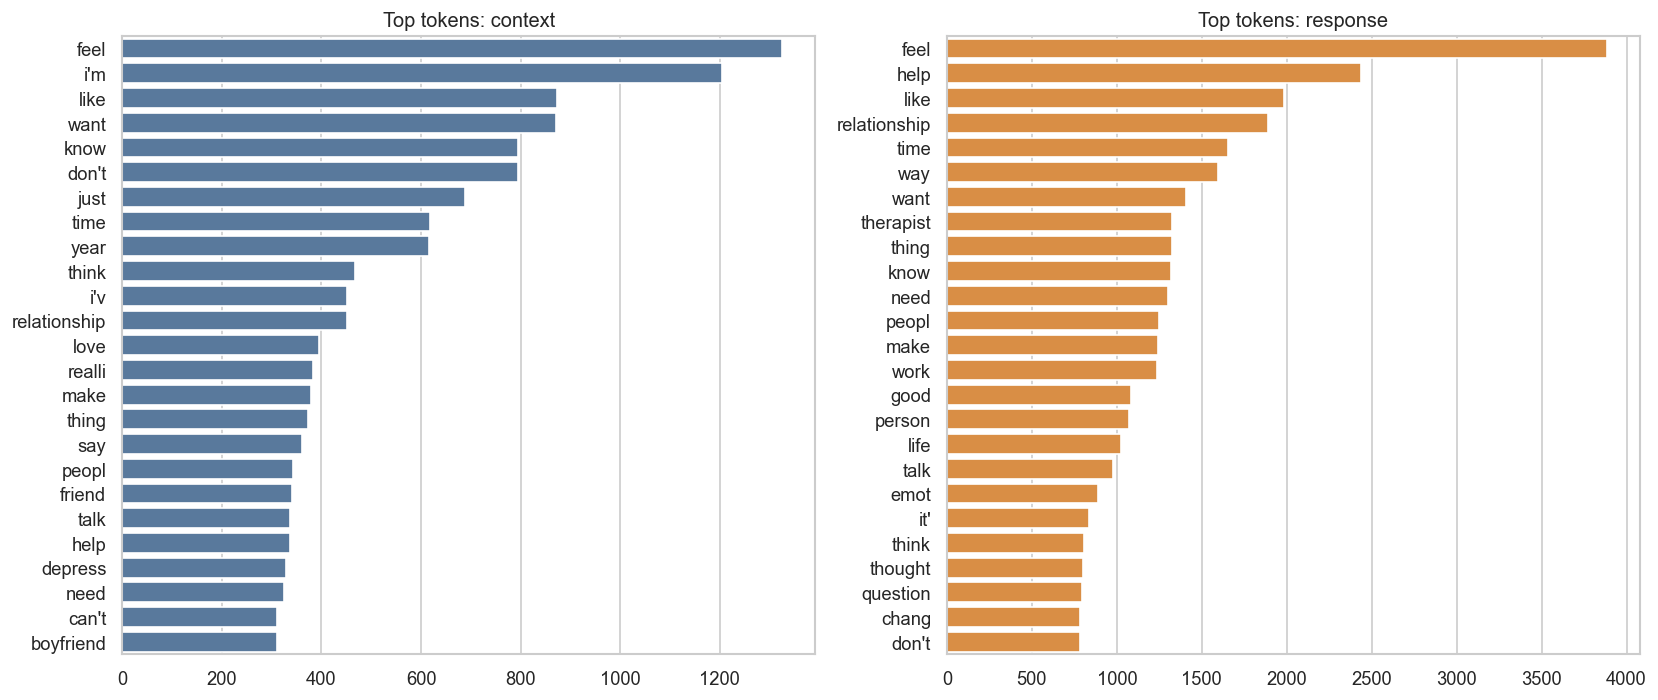

In [23]:
ctx_flat = [t for toks in df["context_tokens"] for t in toks]
rsp_flat = [t for toks in df["response_tokens"] for t in toks]

ctx_freq = Counter(ctx_flat)
rsp_freq = Counter(rsp_flat)

keys_ctx, vals_ctx = zip(*ctx_freq.most_common(25)) if len(ctx_freq) else ([], [])
keys_rsp, vals_rsp = zip(*rsp_freq.most_common(25)) if len(rsp_freq) else ([], [])

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x=list(vals_ctx), y=list(keys_ctx), ax=ax[0], color="#4e79a7")
ax[0].set_title("Top tokens: context")
sns.barplot(x=list(vals_rsp), y=list(keys_rsp), ax=ax[1], color="#f28e2c")
ax[1].set_title("Top tokens: response")
plt.tight_layout()
plt.show()
